In [1]:


!pip install datasets tqdm typing-extensions==4.11.0 --quiet

# 2. IMPORT LIBRARIES
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [2]:

CONFIG = {
    "image_size": (128, 128),
    "batch_size": 64,
    "epochs": 30,
    "num_train_samples": 5000,
    "num_test_samples": 1000,
    "learning_rate": 3e-4,
    "weight_decay": 1e-4,
    "early_stop_patience": 10,
    "lr_patience": 5,

}

In [3]:

# ==============================================
# Data Loading Function
# ==============================================
def load_data(split, n_samples=None):
    """Optimized data loader with error handling"""
    dataset = load_dataset("GVJahnavi/PlantVillage_dataset", split=split, streaming=True)
    images, labels = [], []

    for sample in tqdm(dataset.take(n_samples) if n_samples else dataset, desc=f"Loading {split}"):
        try:
            img = sample['image'].resize(CONFIG["image_size"])
            img_array = np.array(img)

            # Handle grayscale images
            if len(img_array.shape) == 2:
                img_array = np.stack((img_array,)*3, axis=-1)

            images.append(img_array / 255.0)
            labels.append(str(sample['label']))
        except Exception as e:
            continue

    return np.array(images), np.array(labels)


In [4]:
# ==============================================
# Data Loading
# ==============================================
print("Loading data...")
X_train, y_train = load_data("train", CONFIG["num_train_samples"])
X_test, y_test = load_data("test", CONFIG["num_test_samples"])

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


Loading data...


README.md:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

Loading train: 0it [00:00, ?it/s]

Loading test: 0it [00:00, ?it/s]

In [5]:
# ==============================================
# Data Augmentation
# ==============================================
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()


In [6]:
# ==============================================
# Enhanced Model Architecture
# ==============================================
def build_model():
    model = Sequential()
    input_shape = (*CONFIG["image_size"], 3)

    # Conv Blocks
    filters = [32, 64, 128, 256]
    dropouts = [0.25, 0.3, 0.4, 0.5]

    for i, (f, dr) in enumerate(zip(filters, dropouts)):
        # First block has input_shape
        if i == 0:
            model.add(Conv2D(f, (3,3), padding="same", input_shape=input_shape,
                          kernel_regularizer=l2(CONFIG["weight_decay"])))
        else:
            model.add(Conv2D(f, (3,3), padding="same",
                          kernel_regularizer=l2(CONFIG["weight_decay"])))

        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())

        # Add second conv layer for deeper blocks
        if i >= 1:
            model.add(Conv2D(f, (3,3), padding="same"))
            model.add(LeakyReLU(alpha=0.1))
            model.add(BatchNormalization())

        model.add(MaxPooling2D((2,2)))
        model.add(Dropout(dr))

    # Classifier
    model.add(Flatten())
    model.add(Dense(1024, kernel_regularizer=l2(CONFIG["weight_decay"])))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(len(le.classes_), activation='softmax'))

    return model

model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 17,956,231 (68.50 MB)

 Trainable params: 17,952,327 (68.48 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [7]:
# ==============================================
# Training Setup
# ==============================================
optimizer = Adam(learning_rate=CONFIG["learning_rate"],
                 weight_decay=CONFIG["weight_decay"])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]
)

callbacks = [
    EarlyStopping(patience=CONFIG["early_stop_patience"],
                 restore_best_weights=True,
                 monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5,
                     patience=CONFIG["lr_patience"],
                     verbose=1),
]


In [8]:
# ==============================================
# Training Execution
# ==============================================
print("\nTraining model...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=CONFIG["batch_size"]),
    steps_per_epoch=len(X_train) // CONFIG["batch_size"],
    validation_data=val_datagen.flow(X_test, y_test),
    epochs=CONFIG["epochs"],
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.4329 - loss: 2.4943 - sparse_top_k_categorical_accuracy: 0.7645 - val_accuracy: 0.1320 - val_loss: 9.4595 - val_sparse_top_k_categorical_accuracy: 0.2420 - learning_rate: 3.0000e-04
Epoch 2/30
 1/78 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5781 - loss: 1.9116 - sparse_top_k_categorical_accuracy: 0.8750

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5781 - loss: 1.9116 - sparse_top_k_categorical_accuracy: 0.8750 - val_accuracy: 0.1280 - val_loss: 9.3718 - val_sparse_top_k_categorical_accuracy: 0.2420 - learning_rate: 3.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 49s 286ms/step - accuracy: 0.6459 - loss: 1.4719 - sparse_top_k_categorical_accuracy: 0.9345 - val_accuracy: 0.0560 - val_loss: 10.2090 - val_sparse_top_k_categorical_accuracy: 0.2420 - learning_rate: 3.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7656 - loss: 0.9638 - sparse_top_k_categorical_accuracy: 0.9375 - val_accuracy: 0.0560 - val_loss: 10.1537 - val_sparse_top_k_categorical_accuracy: 0.2420 - learning_rate: 3.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 304ms/step - accuracy: 0.7353 - loss: 1.0905 - sparse_top_k_categorical_accuracy: 0.9676 - val_accuracy: 0.0560 - val_loss: 11.6470 - val_sparse_top_k_categorical_accuracy: 0.4430 - learning_rate: 3.0000e-04
Epoch 6/30
78/78 ━

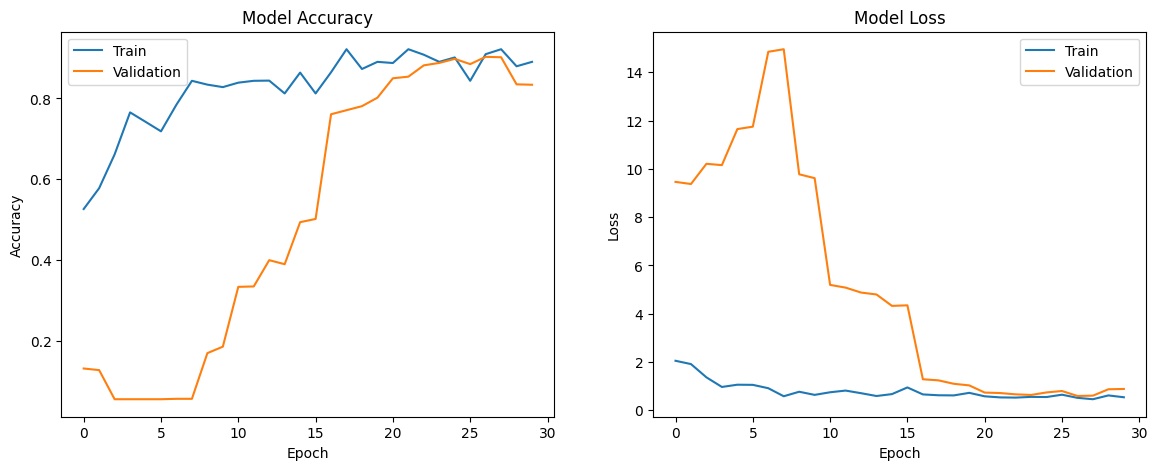

In [9]:
# ==============================================
# Evaluation & Visualization
# ==============================================
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [10]:

# Final evaluation
results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Metrics:")
print(f"Test Accuracy: {results[1]*100:.2f}%")
print(f"Top-3 Accuracy: {results[2]*100:.2f}%")


Final Metrics:
Test Accuracy: 90.30%
Top-3 Accuracy: 99.40%


In [12]:

# Save class names for inference
np.save('detection.npy', le.classes_)
model.save('detectiontest.h5')
print("\nTraining complete! Model and class names saved.")


Training complete! Model and class names saved.
